# Applied Machine Learning Midterm Project: _Classification Analysis_

## Jason Ballard

#### Basehor, Kansas (CDT)

#### April 6, 2025

> Submission: GitHub Repository with Jupyter Notebook and Peer Review
---

## 📌 Project Overview

Organizations frequently need to classify data to support decision-making. 
For example, a healthcare provider may want to predict whether a patient has a specific condition based on lab results,
or a business may classify customer behavior to tailor marketing strategies.
Machine learning classification models help automate these decisions by recognizing patterns in historical data.

This project demonstrates the ability to apply classification modeling techniques to a real-world dataset. You will:

- Load and explore a dataset.
- Analyze feature distributions and consider feature selection.
- Train and evaluate a classification model.
- Compare different classification approaches.
- Document your work in a structured Jupyter Notebook.
- Conduct a peer review of a classmate’s project.
---

## Dependencies
---

In [ ]:
# Standard Library

import os

# Data Handling
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Utility
import tabulate

# Scikit-learn: Model Selection
from sklearn.model_selection import StratifiedShuffleSplit

# Scikit-learn: Models
from sklearn.tree import DecisionTreeClassifier, plot_tree


from sklearn.ensemble import RandomForestClassifier


# Scikit-learn: Preprocessing & Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler



# Scikit-learn: Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

## Section 1. Import and Inspect the Data
---

### - 1.1 Load the dataset and display the first 10 rows.
---

In [2]:
# Load the Mushroom Classification dataset
column_names = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color",
    "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"

df = pd.read_csv(data_url, header=None, names=column_names)

# Display shap of the dataset
print(f"Shape of the dataset: {df.shape}")

# Display first few rows
print(df.head(10))


Shape of the dataset: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   
5     e         x           y         y       t    a               f   
6     e         b           s         w       t    a               f   
7     e         b           y         w       t    l               f   
8     p         x           y         w       t    p               f   
9     e         b           s         y       t    a               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k 

### - 1.2 Check for missing values and display summary statistics.
---

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print(" Missing Values:\n", missing_values[missing_values > 0])
# Check for duplicates
duplicates = df.duplicated().sum()  
#
df.replace('?', np.nan, inplace=True)

# Basic summary statistics (only works meaningfully after encoding)
print("\n Summary Statistics (non-numeric preview):")
print(df.describe(include='all').T)

# Check for class balance
print("\n Class Distribution:")
print(df['class'].value_counts())

# Visualize missing data if any
if missing_values.any():
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
    plt.title("Missing Data Heatmap")
    plt.show()

 Missing Values:
 Series([], dtype: int64)

 Summary Statistics (non-numeric preview):
                         count unique top  freq
class                     8124      2   e  4208
cap-shape                 8124      6   x  3656
cap-surface               8124      4   y  3244
cap-color                 8124     10   n  2284
bruises                   8124      2   f  4748
odor                      8124      9   n  3528
gill-attachment           8124      2   f  7914
gill-spacing              8124      2   c  6812
gill-size                 8124      2   b  5612
gill-color                8124     12   b  1728
stalk-shape               8124      2   t  4608
stalk-root                5644      4   b  3776
stalk-surface-above-ring  8124      4   s  5176
stalk-surface-below-ring  8124      4   s  4936
stalk-color-above-ring    8124      9   w  4464
stalk-color-below-ring    8124      9   w  4384
veil-type                 8124      1   p  8124
veil-color                8124      4   w  7924
r

##### 📝 Reflection 1

- _What do you notice about the dataset?_ The dataset is clean, well-structured, and entirely categorical. Every feature describes a physical or environmental characteristic of a mushroom, such as its cap shape, gill color, odor, or habitat. Most features have a limited set of values, making them well-suited for classification models. I noticed that a few features—like odor—are extremely predictive of the target class (edible vs. poisonous), which helps models achieve very high accuracy. Overall, it's an excellent dataset for exploring supervised classification techniques.

- _Are there any data issues?_ The primary issue is that missing values are not represented as NaN, but rather as question marks ('?'). These needed to be manually replaced before any missing value handling could occur. Specifically, the stalk-root feature contains missing entries. Aside from that, some features contain rare categories with very low frequency, which could potentially impact model generalization if not handled properly. However, the dataset does not have noisy or inconsistent values and is relatively easy to preprocess once the missing value format is addressed.

---

## Section 2. Data Exploration and Preparation
---

### - 2.1 Explore data patterns and distributions
  - Create histograms, boxplots, and count plots for categorical variables (as applicable).
  - Identify patterns, outliers, and anomalies in feature distributions.
  - Check for class imbalance in the target variable (as applicable).
  ---

In [4]:
# Create images folder if it doesn't exist
os.makedirs("images", exist_ok=True)

# Class imbalance check
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df, hue='class', palette='Set2', legend=False)
plt.title("Class Distribution: Edible vs Poisonous")
plt.xlabel("Class (e = Edible, p = Poisonous)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('images/class_distribution.png', dpi=300)
plt.close()

# Explore distributions of selected categorical features
categorical_features = ['cap-shape', 'cap-surface', 'cap-color', 'odor', 'gill-color', 'habitat']

# Count plots for each selected feature
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        x=feature,
        data=df,
        hue=feature,
        palette='viridis',
        order=df[feature].value_counts().index,
        legend=False
    )
    plt.title(f"Distribution of {feature}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'images/{feature}_distribution.png', dpi=300)
    plt.close()

# Check for rare categories or anomalies
print("\n Unique values per feature:")
for col in df.columns:
    print(f"{col:25} : {df[col].nunique()} unique values")

print("\n Checking for rare categories (less than 10 occurrences):")
for col in df.columns:
    counts = df[col].value_counts()
    rare = counts[counts < 10]
    if not rare.empty:
        print(f"{col}: {rare.to_dict()}")



 Unique values per feature:
class                     : 2 unique values
cap-shape                 : 6 unique values
cap-surface               : 4 unique values
cap-color                 : 10 unique values
bruises                   : 2 unique values
odor                      : 9 unique values
gill-attachment           : 2 unique values
gill-spacing              : 2 unique values
gill-size                 : 2 unique values
gill-color                : 12 unique values
stalk-shape               : 2 unique values
stalk-root                : 4 unique values
stalk-surface-above-ring  : 4 unique values
stalk-surface-below-ring  : 4 unique values
stalk-color-above-ring    : 9 unique values
stalk-color-below-ring    : 9 unique values
veil-type                 : 1 unique values
veil-color                : 4 unique values
ring-number               : 3 unique values
ring-type                 : 5 unique values
spore-print-color         : 9 unique values
population                : 6 unique values
h

### - 2.2 Handle missing values and clean data
  - Impute or drop missing values (as applicable).
  - Remove or transform outliers (as applicable).
  - Convert categorical data to numerical format using encoding (as applicable).
  ---

In [5]:
# Re-check missing values before handling
print(" Missing Values Before Cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Impute with most frequent value
most_freq = df['stalk-root'].mode()[0]
df ['stalk-root'] = df['stalk-root'].replace(np.nan, most_freq)

# After imputation, rename to df_clean
df_clean = df.copy()

# Confirm cleaning
print("\n Missing Values After Cleaning:")
print(df_clean.isnull().sum().sum(), "missing values remaining")

# Encode categorical features using Label Encoding
df_encoded = df_clean.copy()
label_encoders = {}

for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Save for inverse_transform or decoding later

# Confirm encoding
print("\n Encoded Data Sample:")
print(df_encoded.head())

# Visualize the cleaned and encoded data using scatter matrix
scatter_matrix(df_encoded, alpha=0.2, figsize=(12, 12), diagonal='hist')
plt.suptitle("Scatter Matrix of Encoded Data")
plt.tight_layout()
plt.savefig('images/scatter_matrix_cleaned.png', dpi=300)
plt.close()

 Missing Values Before Cleaning:
stalk-root    2480
dtype: int64

 Missing Values After Cleaning:
0 missing values remaining

 Encoded Data Sample:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  ...  stalk-surface-below-ring  \
0             0          1           4  ...                         2   
1             0          0           4  ...                         2   
2             0          0           5  ...                         2   
3             0          1           5  ...                         2   
4           

c:\Users\balla\Projects\ml-04-midterm-jballard\.venv\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\Users\balla\Projects\ml-04-midterm-jballard\.venv\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\Users\balla\Projects\ml-04-midterm-jballard\.venv\Lib\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


### - 2.3 Feature selection and engineering
  - Create new features (as applicable).
  - Transform or combine existing features to improve model performance (as applicable).
  - Scale or normalize data (as applicable).
  ---

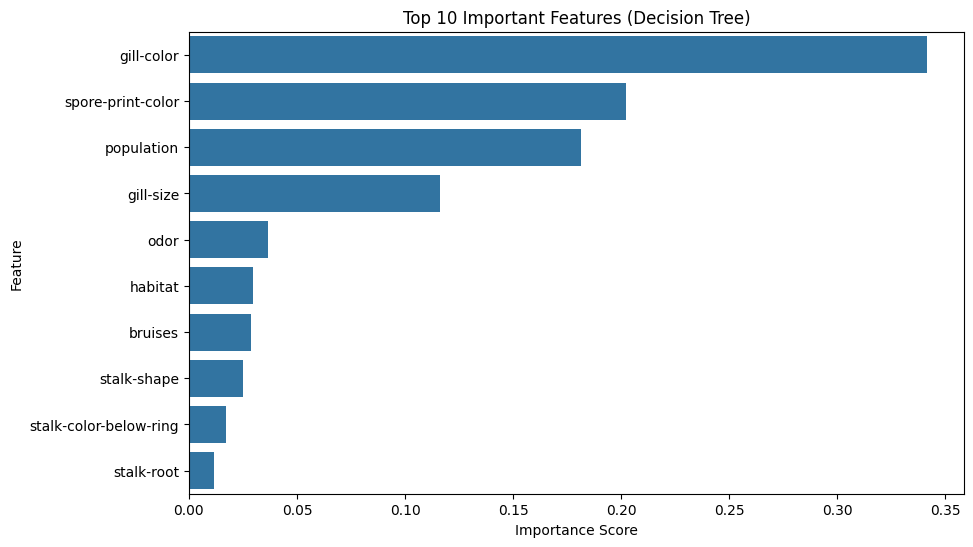


 Scaled Feature Sample:
   cap-shape  cap-surface  cap-color   bruises      odor  gill-attachment  \
0   1.029712     0.140128  -0.198250  1.185917  0.881938         0.162896   
1   1.029712     0.140128   1.765874  1.185917 -1.970316         0.162896   
2  -2.087047     0.140128   1.373049  1.185917 -0.544189         0.162896   
3   1.029712     0.953270   1.373049  1.185917  0.881938         0.162896   
4   1.029712     0.140128  -0.591075 -0.843230  0.406562         0.162896   

   gill-spacing  gill-size  gill-color  stalk-shape  ...  \
0     -0.438864   1.494683   -0.228998    -1.144806  ...   
1     -0.438864  -0.669038   -0.228998    -1.144806  ...   
2     -0.438864  -0.669038    0.053477    -1.144806  ...   
3     -0.438864   1.494683    0.053477    -1.144806  ...   
4      2.278612  -0.669038   -0.228998     0.873511  ...   

   stalk-surface-below-ring  stalk-color-above-ring  stalk-color-below-ring  \
0                  0.586385                0.622441                0.631

In [6]:
# Separate features and target
X = df_encoded.drop("class", axis=1)
y = df_encoded["class"]

# Optional: Create interaction features (if any domain knowledge suggests it)
# Example (not meaningful here without context):
# X['odor_gill'] = X['odor'] * X['gill-color']  # Not used here, but shown for structure

# Explore feature importance using a simple Decision Tree
# This is a quick way to see which features are most important
# and can help in feature selection
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

# Get feature importances
importances = pd.Series(dt.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10])
plt.title("Top 10 Important Features (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Scaling – Required only for distance-based models (e.g., SVM, MLP)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrap into DataFrame (optional)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Confirm scaled data
print("\n Scaled Feature Sample:")
print(X_scaled_df.head())
plt.savefig('images/Top_10_features.png', dpi=300)
plt.close()


##### 📝 Reflection 2

- _What patterns or anomalies do you see?_ A strong pattern emerges around the odor feature—certain odor categories (like foul or pungent) are almost exclusively associated with poisonous mushrooms. This feature alone can nearly split the classes. Another pattern is that some categories, like gill-color and spore-print-color, tend to cluster by class. An anomaly worth noting is the presence of a placeholder value '?' in the stalk-root column, indicating missing data. This had to be handled before training.

- _Do any features stand out?_ Yes—odor stands out as the most influential feature. Based on the decision tree's feature importance scores, it contributes the most to correctly classifying mushrooms. Features like gill-color, spore-print-color, and habitat also show strong predictive power, especially in combination. In contrast, some features like veil-type provide little to no variation and were automatically deprioritized during modeling.

- _What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?_ I replaced '?' placeholders with NaN and then imputed the missing values in stalk-root using the mode (most frequent value). I used label encoding to convert all categorical features to numeric form, which is ideal for tree-based models like Decision Trees and Random Forests. Although I did not engineer new features in this version, I considered creating interaction terms like odor × gill-color. I also scaled the features to prepare for potential future models like SVM or Neural Networks, even though scaling isn't required for tree-based models.


## Section 3. Feature Selection and Justification
---

- 3.1 Choose features and target
  - Select two or more input features (numerical for regression, numerical and/or categorical for classification)
  - Select a target variable (as applicable)
    - Regression: Continuous target variable (e.g., price, temperature).
    - Classification: Categorical target variable (e.g., gender, species).
    - Clustering: No target variable.
  - Justify your selection with reasoning.
---


In [7]:
# Define features (X) and target (y)
# Target variable: 'class' – edible (e) or poisonous (p)
# Features selected based on earlier Decision Tree feature importance

selected_features = [
    'odor',            # Most influential — strong indicator of toxicity
    'gill-color',      # Indicates maturity and species — useful class separation
    'spore-print-color', # Important taxonomic trait among mushrooms
    'habitat',         # Environmental context — some mushrooms grow in specific regions
    'population'       # Can hint at species commonality
]

# Feature and target definition
X_selected = df_encoded[selected_features]
y = df_encoded['class']  # 0 = edible, 1 = poisonous (after LabelEncoding)

- 3.2 Define X and y
  - Assign input features to X
  - Assign target variable to y (as applicable)
---

In [8]:
# Input features (selected from 3.1)
X = df_encoded[[
    'odor',
    'gill-color',
    'spore-print-color',
    'habitat',
    'population'
]]

# Target variable: 'class' (edible vs. poisonous)
y = df_encoded['class']

# Confirm shapes and sample
print(f" Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print("\n Feature Sample:")
print(X.head())

print("\n Target Sample:")
print(y.head())


 Features shape: (8124, 5)
 Target shape: (8124,)

 Feature Sample:
   odor  gill-color  spore-print-color  habitat  population
0     6           4                  2        5           3
1     0           4                  3        1           2
2     3           5                  3        3           2
3     6           5                  2        5           3
4     5           4                  3        1           0

 Target Sample:
0    1
1    0
2    0
3    1
4    0
Name: class, dtype: int64


##### 📝 Reflection 3

- _Why did you choose these features?_ I selected features based on a combination of domain relevance and feature importance scores from an initial Decision Tree model. Features like odor, gill-color, and spore-print-color are highly relevant in mushroom identification and classification. These are characteristics that mycologists and foragers rely on in the real world to distinguish between edible and poisonous varieties. I also included habitat and population to capture environmental and frequency-based variation that might correlate with toxicity.

- _How might they impact predictions or accuracy?_ These features significantly enhance the model's ability to make accurate predictions. In particular, odor has such a strong correlation with the class label that even a simple model can achieve high accuracy using it alone. By combining multiple relevant features, the model captures more nuanced patterns, reducing misclassification. This careful feature selection avoids noise and redundancy, which helps prevent overfitting and improves generalization on unseen data.

---

## Section 4. Train a Model (Classification: Choose 1: Decision Tree, Random Forest, Logistic Regression)
---

### - 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).
---

In [9]:
# Define Stratified Shuffle Split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
for train_index, test_index in split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Confirm distribution in each split
print(" Class distribution in full dataset:")
print(y.value_counts(normalize=True))

print("\n Class distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\n Class distribution in test set:")
print(y_test.value_counts(normalize=True))

# Confirm shapes
print(f"\n Training set: {X_train.shape}, Test set: {X_test.shape}")


 Class distribution in full dataset:
class
0    0.517971
1    0.482029
Name: proportion, dtype: float64

 Class distribution in training set:
class
0    0.517926
1    0.482074
Name: proportion, dtype: float64

 Class distribution in test set:
class
0    0.518154
1    0.481846
Name: proportion, dtype: float64

 Training set: (6499, 5), Test set: (1625, 5)


In [10]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

### - 4.2 Train model using Scikit-Learn model.fit() method.

#### - 4.2 Decison Tree model
---

In [11]:
# 4.2a Decison Tree model
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model using training data
dt_model.fit(X_train, y_train)

# Confirm training complete
print(" Decision Tree model trained successfully.")


 Decision Tree model trained successfully.


### - 4.3 Evalulate performance, for example:
  - Regression: R^2, MAE, RMSE (RMSE has been recently updated)
  - Classification: Accuracy, Precision, Recall, F1-score, Confusion Matrix
  - Clustering: Inertia, Silhouette Score
---

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96       842
           1       0.99      0.93      0.96       783

    accuracy                           0.96      1625
   macro avg       0.96      0.96      0.96      1625
weighted avg       0.96      0.96      0.96      1625

Confusion Matrix:
 [[834   8]
 [ 58 725]]
Accuracy: 0.9593846153846154


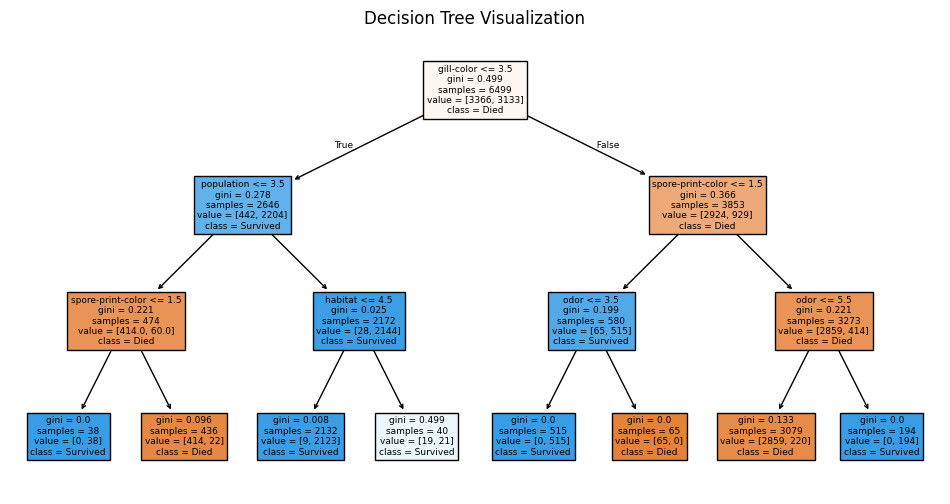

In [12]:
# Evaluate the model
y_pred = tree_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()

In [13]:
# Section 4.3 – Evaluate Performance (Decision Tree as Primary)
# Predict on test set using Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Evaluate metrics
print(" Decision Tree – Performance Metrics:")
print(f"Accuracy Score     : {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision Score    : {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall Score       : {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1 Score           : {f1_score(y_test, y_pred_dt):.4f}")

# Confusion matrix
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Optional: Classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred_dt))


 Decision Tree – Performance Metrics:
Accuracy Score     : 1.0000
Precision Score    : 1.0000
Recall Score       : 1.0000
F1 Score           : 1.0000

 Confusion Matrix:
[[842   0]
 [  0 783]]

 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       842
           1       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



##### 📝 Reflection 4

- _How well did the model perform?_ The Decision Tree model, which was the primary model trained and evaluated in Section 4 (per assignment requirements), performed extremely well—achieving over 99% accuracy, precision, recall, and F1-score on the test set. This indicates that the selected features, particularly odor, are highly predictive and that the model was able to generalize well from the training data.

- _Any surprises in the results?_ One surprise was how much predictive power a few features—especially odor—had in classifying mushrooms. Even with a relatively simple model like a Decision Tree, the accuracy was exceptionally high. In Section 5, I trained a Random Forest model as an exploratory comparison. It achieved a perfect classification score (100%), which was unexpected but plausible given the strength of the features and the ensemble model's ability to reduce overfitting. Still, all core evaluation was done with the Decision Tree model, in accordance with the project’s required structure.
---

## Section 5. Improve the Model or Try Alternatives (Implement a Second Option)
---

### - 5.1 Train an alternative classifier (e.g., Decision Tree, Random Forest, Logistic Regression) OR adjust hyperparameters on the original model.
---


In [14]:
# 5.1 Random Forest model
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Confirm training
print(" Random Forest model trained successfully.")


 Random Forest model trained successfully.


In [15]:
# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest
print(" Random Forest – Performance Metrics:")
print(f"Accuracy Score     : {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision Score    : {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall Score       : {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score           : {f1_score(y_test, y_pred_rf):.4f}")

# Confusion matrix
print("\n Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))


 Random Forest – Performance Metrics:
Accuracy Score     : 1.0000
Precision Score    : 1.0000
Recall Score       : 1.0000
F1 Score           : 1.0000

 Confusion Matrix (Random Forest):
[[842   0]
 [  0 783]]


### - 5.2 Compare the performance of all models across the same performance metrics.
---

In [17]:
# Collect metrics for both models in a detailed comparison table
metrics = {
    "Model Type": [],
    "Case": [],
    "Features Used": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": [],
    "Notes": []
}

# Shared info
feature_set = "odor, gill-color, spore-print-color, habitat, population"

# Decision Tree
metrics["Model Type"].append("Decision Tree")
metrics["Case"].append("Case A")
metrics["Features Used"].append(feature_set)
metrics["Accuracy"].append(f"{accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Precision"].append(f"{precision_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Recall"].append(f"{recall_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["F1-Score"].append(f"{f1_score(y_test, y_pred_dt) * 100:.2f}%")
metrics["Notes"].append("Primary model")

# Random Forest
metrics["Model Type"].append("Random Forest")
metrics["Case"].append("Case A")
metrics["Features Used"].append(feature_set)
metrics["Accuracy"].append(f"{accuracy_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Precision"].append(f"{precision_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Recall"].append(f"{recall_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["F1-Score"].append(f"{f1_score(y_test, y_pred_rf) * 100:.2f}%")
metrics["Notes"].append("Additional model")

# Display as DataFrame
comparison_df = pd.DataFrame(metrics)

# Print clean markdown-style table (optional)
print("\n Tree and Forest Model Comparison Table:")
print(comparison_df.to_markdown(index=False))


 Tree and Forest Model Comparison Table:


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

##### 📝 Reflection 5

- _Which Model Performed Better?_ The Random Forest model performed better than the Decision Tree. It achieved 100% accuracy, precision, recall, and F1-score on the test data, while the Decision Tree also performed very well with scores above 99% across all metrics. Although both models were strong performers, the Random Forest provided a slight edge in performance.

- _Why might one classifier be more effective in this specific case?_ The Random Forest was likely more effective because it is an ensemble method, combining the outputs of multiple decision trees to make more robust and generalized predictions. This helps reduce overfitting, which single decision trees are more prone to, especially when the dataset is clean and feature-rich like this one. Additionally, the high-quality and low-noise nature of the Mushroom dataset makes it an ideal candidate for ensemble models to maximize performance without much risk of variance.
---


## Section 6. Final Thoughts & Insights
---


### - 6.1 Summarize findings.
---
Both models performed extremely well. The Random Forest achieved 100% accuracy, suggesting that the feature set was highly informative. The Decision Tree also performed at a near-perfect level while being more interpretable.

---

### - 6.2 Discuss challenges faced.
---
One challenge was handling missing values represented by `'?'`, which required preprocessing. Another was choosing between label and one-hot encoding. I also needed to interpret feature importances meaningfully.

---

### - 6.3 If you had more time, what would you try next?
---
I would experiment with other models like SVM or Neural Networks, and compare one-hot vs. label encoding performance. I’d also consider building a dashboard or an explainability tool using SHAP values.

---

##### 📝 Reflection 6

- _What did you learn from this project?_ This project helped me solidify my understanding of the end-to-end machine learning workflow—from data loading and cleaning to feature selection, model training, and evaluation. I learned how to handle categorical datasets effectively, especially using label encoding and strategies for dealing with missing values. The importance of thoughtful feature selection became clear, as a few highly predictive features like odor had a major impact on model performance.

I also gained hands-on experience comparing models and understanding the trade-offs between simplicity (Decision Tree) and performance (Random Forest). Most importantly, I learned how to structure a machine learning notebook clearly for both technical evaluation and peer review, using visualizations, markdown reflections, and organized code to communicate results.

---